In [2]:
from datetime import datetime
from datetime import timedelta
import shapefile
import xml.etree.ElementTree as ET
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from pymongo import MongoClient
%matplotlib inline

In [10]:
tree = ET.parse('/media/amassaro/external_2T/telecom_bigdata_2015/data/external_data/xml_incidenti_mar-apr_2015.xml')
root=tree.getroot()
child=list(root)[1]

In [11]:
acc_times=[]
place=[]
for j in child:
    if 'Latitudine' in j.attrib.keys() and 'Longitudine' in j.attrib.keys():
        place.append([float(j.attrib['Longitudine']),float(j.attrib['Latitudine'])])
        acc_times.append(j.attrib['DataOraIncidente'])

acc_times=np.array([datetime.strptime(t[:10]+' '+t[11:],'%Y-%m-%d %H:%M:%S') for t in acc_times])
place=np.array(place)

In [3]:
shp='/media/amassaro/external_2T/telecom_bigdata_2015/data/tim_grid/roma-grid/intersection_Roma_W_GRIDIT_NEW'
crt=shapefile.Reader(shp)
geomet=crt.shapeRecords()
ids=np.array([g.record[0] for g in geomet])

In [13]:
inProj = Proj(init='epsg:32632')
outProj = Proj(init='epsg:4326')
grid=[]
for g in geomet:
    item=[]
    for c in g.shape.points:  
        x2,y2 = transform(inProj,outProj,c[0],c[1])
        item.append([x2,y2])
    grid.append(item)   
grid=np.array(grid)
A=np.array([Polygon(g.shape.points).area for g in geomet])
A=A/min(A)

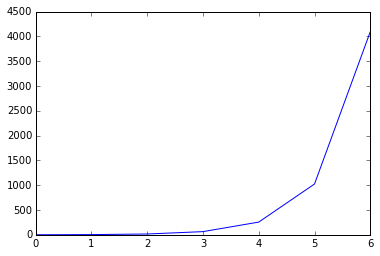

In [14]:
plt.plot(np.sort(list(set(A))))
plt.show()

In [15]:
I=np.zeros(len(grid))
for i  in range(len(grid)):
    t=grid[i]
    polygon=Polygon(t)
    for p in place:
        point=Point(p)
        if polygon.contains(point):
            I[i]+=1   

In [8]:
I_n=np.zeros(len(grid))
for i in range(len(I_n)):
    I_n[i]=I[i]/A[i]

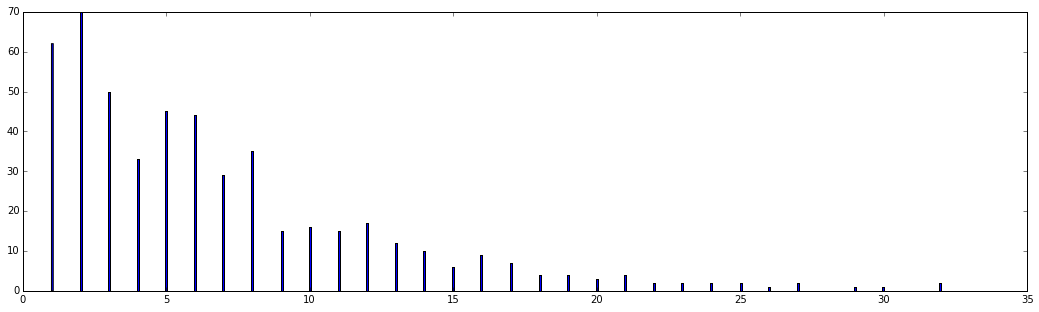

In [9]:
plt.hist(I[(I!=0)&(I<40)],500)
plt.gcf().set_size_inches(18, 5)
plt.show()

In [10]:
db=MongoClient()
db=db['call_in_roma']
cur=db['callIn'].find()
total_calls_in=np.zeros(len(ids))
total_calls_in_n=np.zeros(len(ids))
total_time_in=np.zeros(len(ids))
total_time_in_n=np.zeros(len(ids))
for c in cur:
    cell=c["square_id"]
    index=np.where(ids==cell)[0][0]
    total_calls_in[index]+=c['n_of_calls']
    total_time_in[index]+=c['call_time']
for i in range(len(total_calls_in)):
    total_calls_in_n[i]=total_calls_in[i]/A[i]
    total_time_in_n[i]=total_time_in[i]/A[i]

KeyboardInterrupt: 

distribution of total call-in time across cells, not considering 0-cells


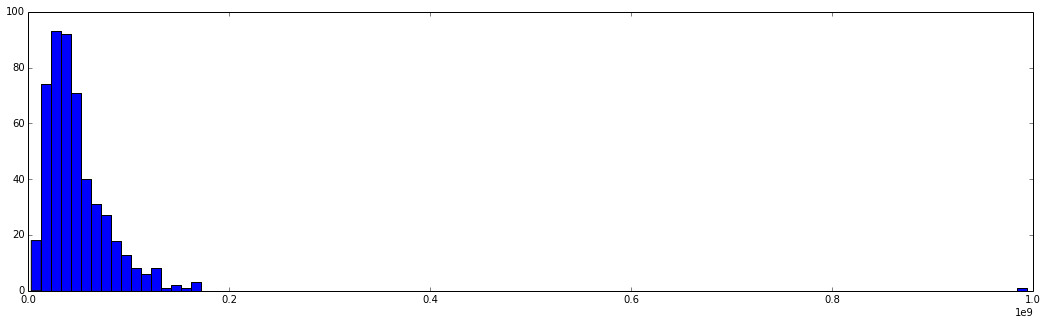

distribution of total call-in time across cells, normalized by cell size, not considering 0-cells


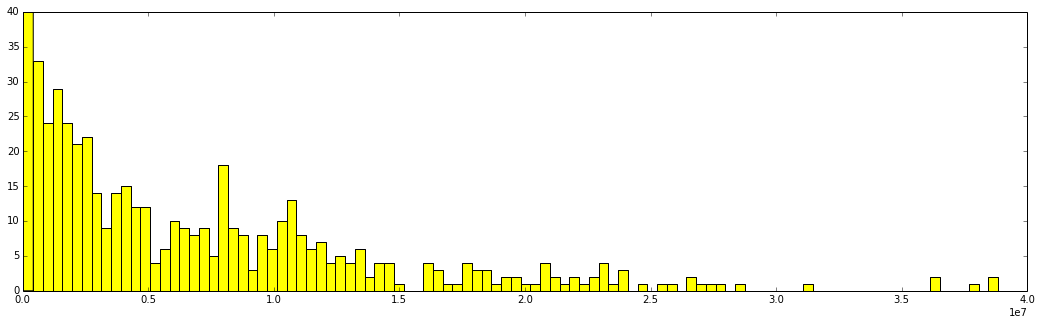

distribution of total number of calls across cells, not considering 0-cells


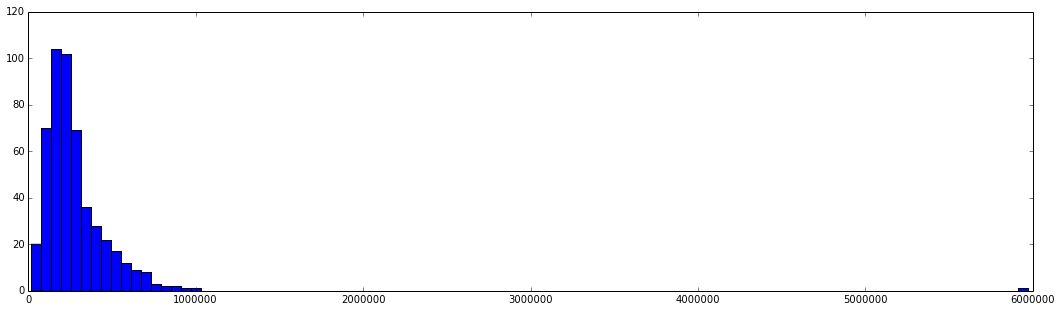

distribution of total number of calls across cells, normalized by cell size, not considering 0-cells


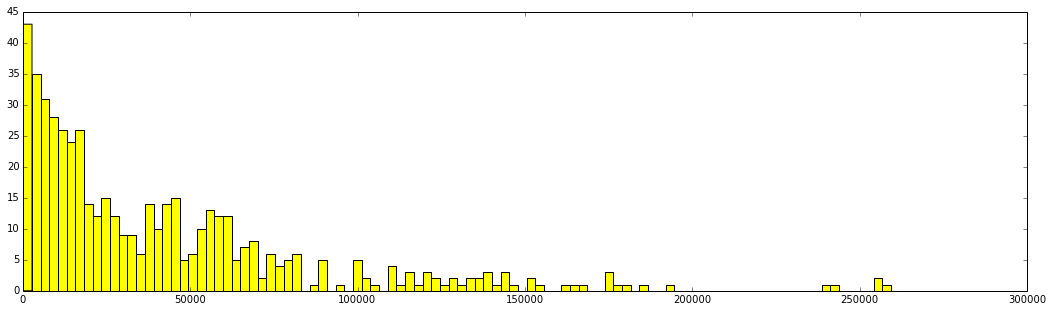

In [100]:
print('distribution of total call-in time across cells, not considering 0-cells')
plt.hist(total_time_in[I>0],100,color='blue')
plt.gcf().set_size_inches(18, 5)
plt.show()

print('distribution of total call-in time across cells, normalized by cell size, not considering 0-cells')
plt.hist(total_time_in_n[I>0],100,color='yellow')
plt.gcf().set_size_inches(18, 5)
plt.show()

print('distribution of total number of calls across cells, not considering 0-cells')
plt.hist(total_calls_in[I>0],100,color='blue')
plt.gcf().set_size_inches(18, 5)
plt.show()

print('distribution of total number of calls across cells, normalized by cell size, not considering 0-cells')
plt.hist(total_calls_in_n[I>0],100,color='yellow')
plt.gcf().set_size_inches(18, 5)
plt.show()

normalized calls TIME vs normalized number of accidents


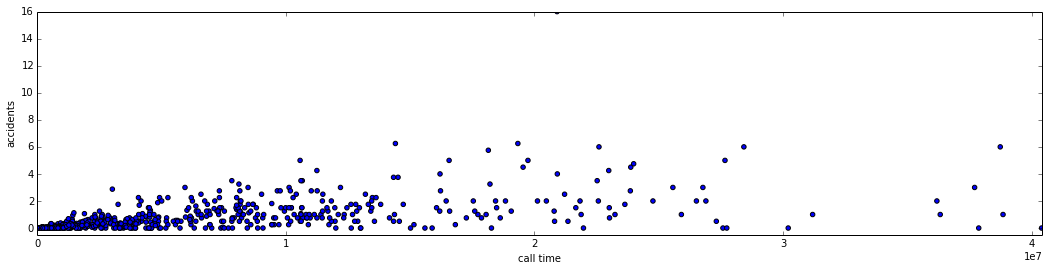

normalized calls TIME vs normalized number of accidents, zoomed in


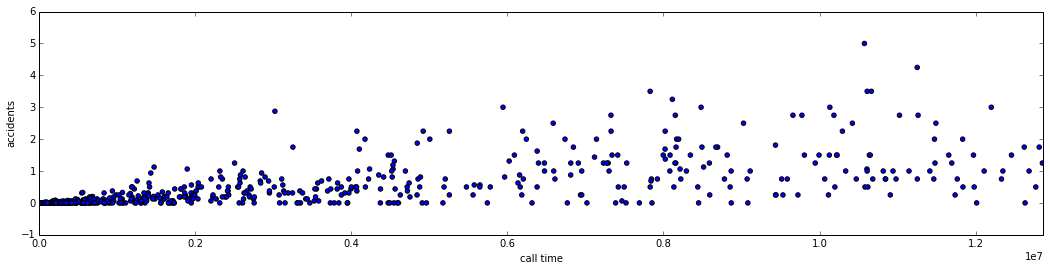

avg normalized TIME calls vs normalized number of accidents


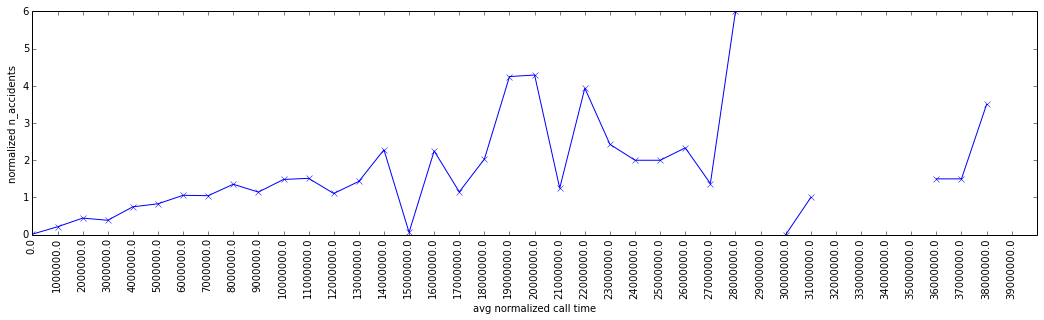

avg normalized TIME calls vs normalized number of accidents, zoomed in


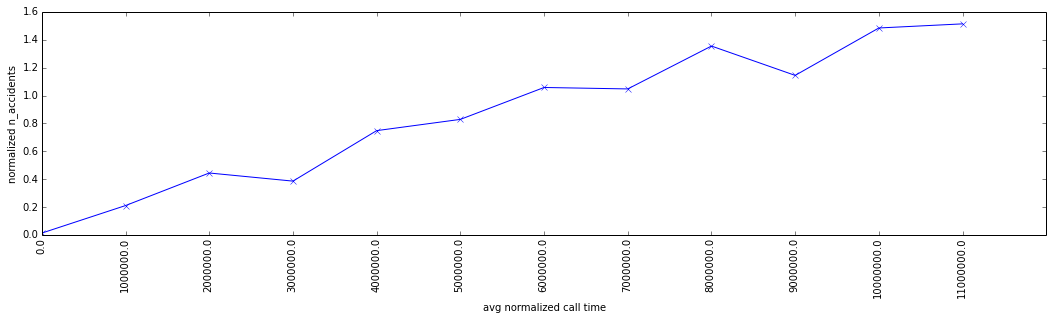

In [244]:
print('normalized calls TIME vs normalized number of accidents')
plt.scatter(total_time_in_n,I_n)
plt.gcf().set_size_inches(18, 4)
plt.xlabel('call time')
plt.ylabel('accidents')
plt.xlim(-.05,max(total_time_in_n))
plt.ylim(-.5,max(I_n))
plt.show()
print('normalized calls TIME vs normalized number of accidents, zoomed in')
P=np.percentile(total_time_in_n,90)
plt.scatter(total_time_in_n[(total_time_in_n<P)],I_n[(total_time_in_n<P)])
plt.gcf().set_size_inches(18, 4)
plt.xlabel('call time')
plt.ylabel('accidents')
plt.xlim(-.05,P)
plt.show()

print('avg normalized TIME calls vs normalized number of accidents')
step=1000000.
philter=[step*k for k in range(int(max(total_time_in_n)/step))]
plt.plot([np.average(I_n[(total_time_in_n>=k)&(total_time_in_n<k+step)]) for k in philter ],marker='x')
plt.xticks([ k for k in range(len(philter))],philter,rotation='vertical')
plt.gcf().set_size_inches(18, 4)
plt.ylabel('normalized n_accidents')
plt.xlabel('avg normalized call time')
plt.show()

print('avg normalized TIME calls vs normalized number of accidents, zoomed in')
step=1000000.
philter=[step*k for k in range(int(P/step))]
plt.plot([np.average(I_n[(total_time_in_n>=k)&(total_time_in_n<k+step)]) for k in philter ],marker='x')
plt.xticks([ k for k in range(len(philter))],philter,rotation='vertical')
plt.gcf().set_size_inches(18, 4)
plt.ylabel('normalized n_accidents')
plt.xlabel('avg normalized call time')
plt.show()



normalized calls NUMBER vs normalized number of accidents


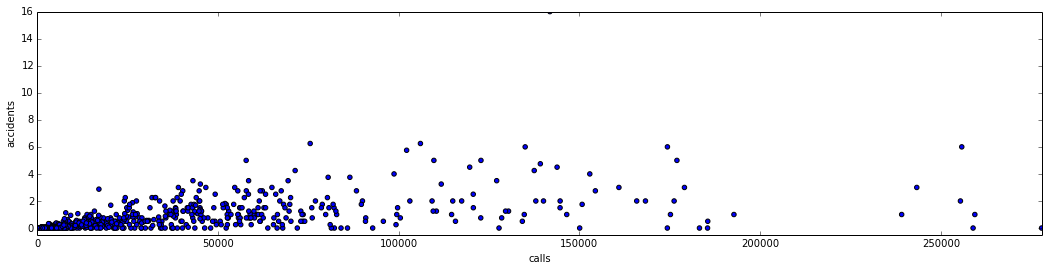

normalized calls NUMBER vs normalized number of accidents, zoomed in


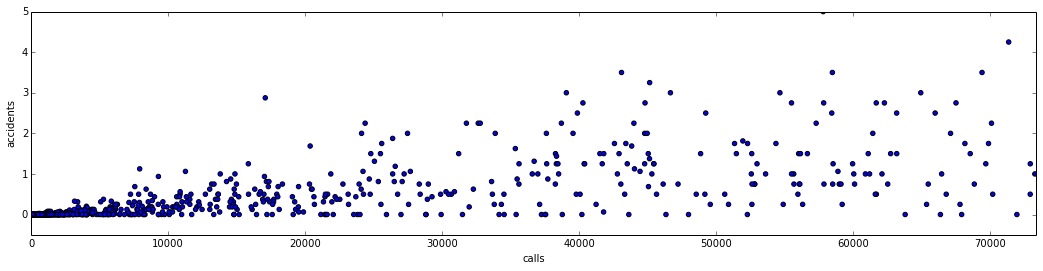

avg normalized NUMBER calls vs normalized number of accidents


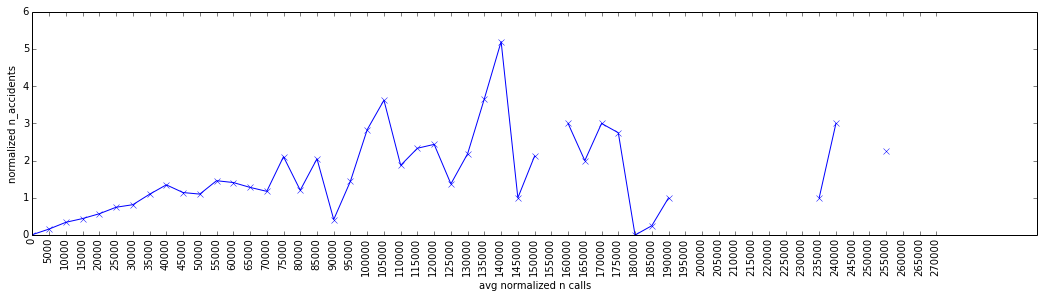

avg normalized NUMBER calls vs normalized number of accidents, zoomed in


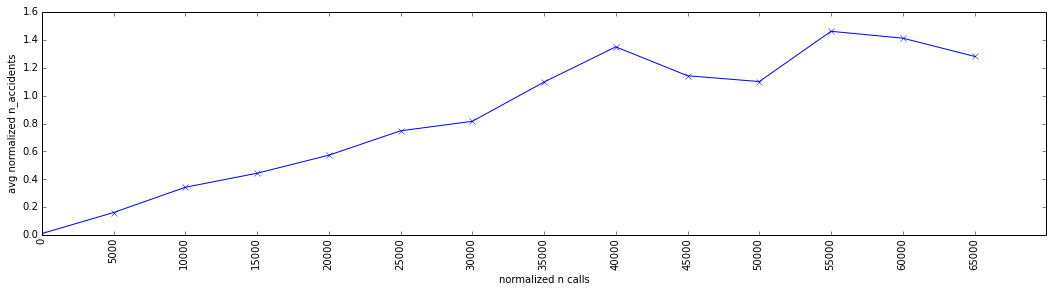

In [246]:


print('normalized calls NUMBER vs normalized number of accidents')
plt.scatter(total_calls_in_n,I_n)
plt.gcf().set_size_inches(18, 4)
plt.xlabel('calls')
plt.ylabel('accidents')
#plt.xticks([ k for k in range(10)],[ k for k in range(10)])
plt.xlim(-.05,max(total_calls_in_n))
plt.ylim(-.5,max(I_n))
plt.show()
print('normalized calls NUMBER vs normalized number of accidents, zoomed in')
P=np.percentile(total_calls_in_n,90)
plt.scatter(total_calls_in_n[(total_calls_in_n<P)],I_n[(total_calls_in_n<P)])
plt.gcf().set_size_inches(18, 4)
plt.xlabel('calls')
plt.ylabel('accidents')
#plt.xticks([ k for k in range(10)],[ k for k in range(10)])
plt.xlim(0,P)
plt.ylim(-.5,max(I_n[total_calls_in_n<P]))
plt.show()

print('avg normalized NUMBER calls vs normalized number of accidents')
philter=[5000*k for k in range(int(max(total_calls_in_n)/5000.))]
plt.plot([np.average(I_n[(total_calls_in_n>=k)&(total_calls_in_n<k+5000)]) for k in philter ],marker='x')
plt.xticks([ k for k in range(len(philter))],philter,rotation='vertical')
plt.gcf().set_size_inches(18, 4)
plt.ylabel('normalized n_accidents')
plt.xlabel('avg normalized n calls')
plt.show()

print('avg normalized NUMBER calls vs normalized number of accidents, zoomed in')
philter=[5000*k for k in range(int(P/5000.))]
plt.plot([np.average(I_n[(total_calls_in_n>=k)&(total_calls_in_n<k+5000)]) for k in philter ],marker='x')
plt.xticks([ k for k in range(len(philter))],philter,rotation='vertical')
plt.gcf().set_size_inches(18, 4)
plt.ylabel('avg normalized n_accidents')
plt.xlabel('normalized n calls')
plt.show()


calls NUMBER vs number of accidents


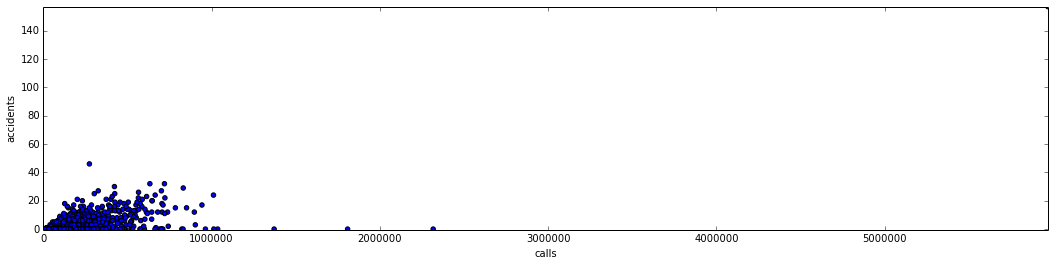

calls NUMBER vs number of accidents, zoomed in


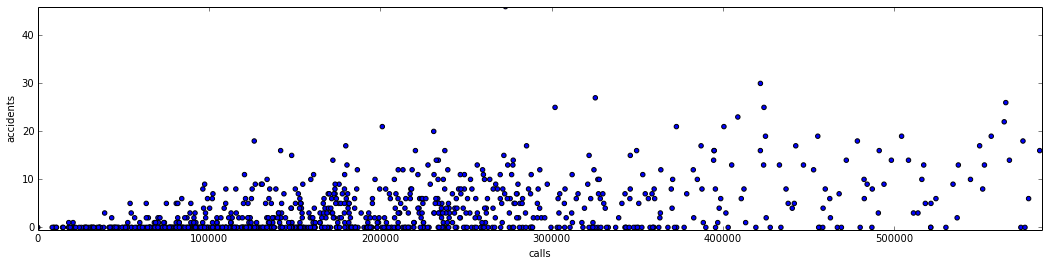

calls NUMBER vs number of accidents, no zero cells, zoomed in


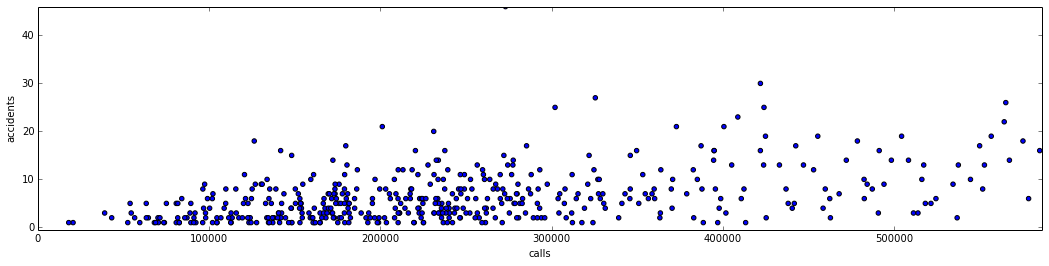

NUMBER calls vs number of accidents, zoomed in


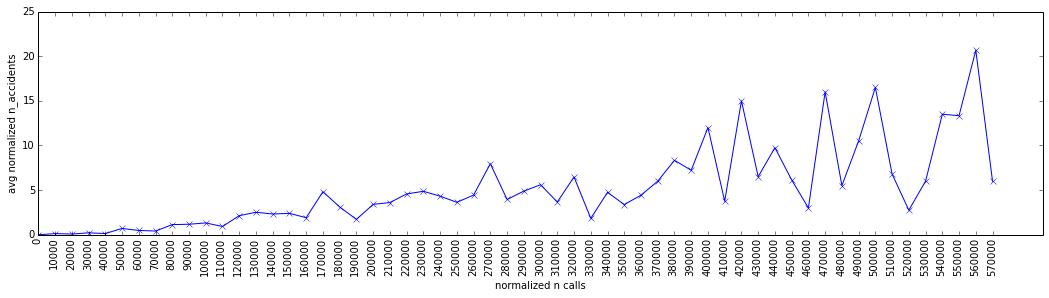

NUMBER calls vs number of accidents, zoomed in, no zero-cells


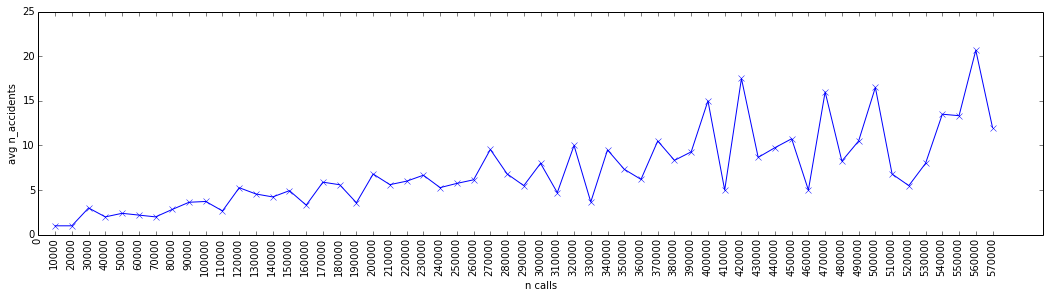

In [260]:

print('calls NUMBER vs number of accidents')
plt.scatter(total_calls_in,I)
plt.gcf().set_size_inches(18, 4)
plt.xlabel('calls')
plt.ylabel('accidents')
#plt.xticks([ k for k in range(10)],[ k for k in range(10)])
plt.xlim(-.05,max(total_calls_in))
plt.ylim(-.5,max(I))
plt.show()

print('calls NUMBER vs number of accidents, zoomed in')
P=np.percentile(total_calls_in,95)
plt.scatter(total_calls_in[(total_calls_in<P)],I[(total_calls_in<P)])
plt.gcf().set_size_inches(18, 4)
plt.xlabel('calls')
plt.ylabel('accidents')
#plt.xticks([ k for k in range(10)],[ k for k in range(10)])
plt.xlim(0,P)
plt.ylim(-.5,max(I[total_calls_in<P]))
plt.show()

print('calls NUMBER vs number of accidents, no zero cells, zoomed in')
P=np.percentile(total_calls_in,95)
plt.scatter(total_calls_in[(total_calls_in<P)&(I>0)],I[(total_calls_in<P)&(I>0)])
plt.gcf().set_size_inches(18, 4)
plt.xlabel('calls')
plt.ylabel('accidents')
#plt.xticks([ k for k in range(10)],[ k for k in range(10)])
plt.xlim(0,P)
plt.ylim(-.5,max(I[total_calls_in<P]))
plt.show()

print('NUMBER calls vs number of accidents, zoomed in')
step=10000
philter=[step*k for k in range(int(P/step))]
plt.plot([np.average(I[(total_calls_in>=k)&(total_calls_in<k+step)]) for k in philter ],marker='x')
plt.xticks([ k for k in range(len(philter))],philter,rotation='vertical')
plt.gcf().set_size_inches(18, 4)
plt.ylabel('avg normalized n_accidents')
plt.xlabel('normalized n calls')
plt.show()


print('NUMBER calls vs number of accidents, zoomed in, no zero-cells')
step=10000
philter=[step*k for k in range(int(P/step))]
plt.plot([np.average(I[(total_calls_in>=k)&(total_calls_in<k+step)&(I>0)]) for k in philter ],marker='x')
plt.xticks([ k for k in range(len(philter))],philter,rotation='vertical')
plt.gcf().set_size_inches(18, 4)
plt.ylabel('avg n_accidents')
plt.xlabel('n calls')
plt.show()


calls TIME vs number of accidents


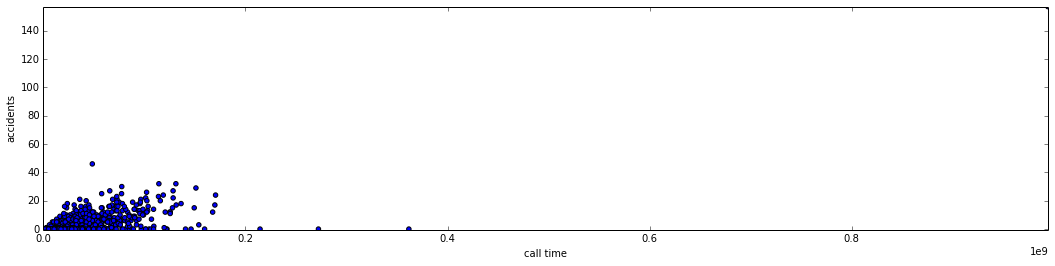

calls TIME vs number of accidents, zoomed in


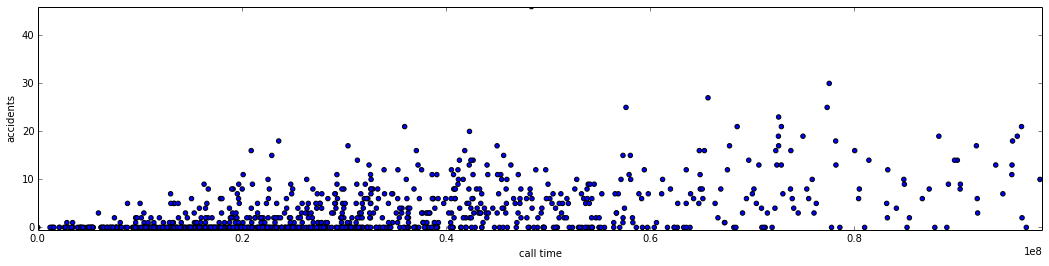

calls TIME vs number of accidents, no zero cells, zoomed in


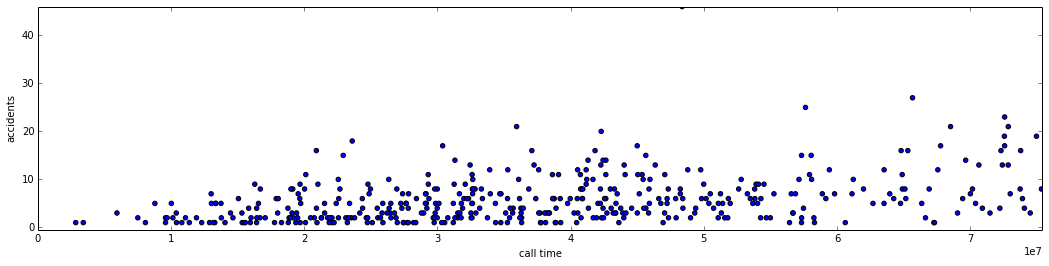

calls TIME vs number of accidents, zoomed in


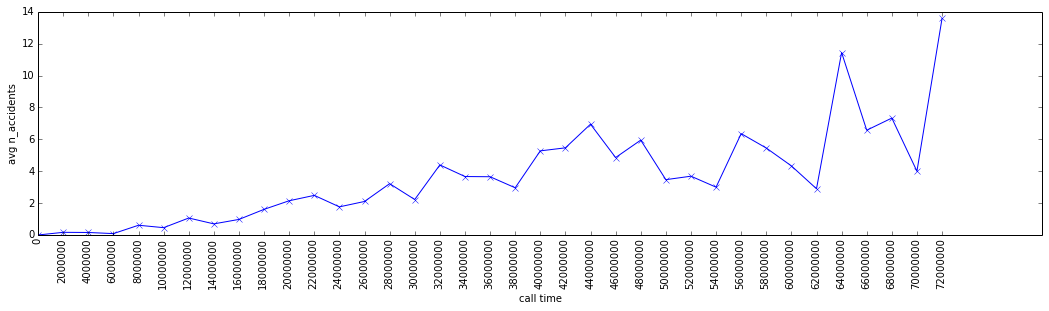

calls TIME vs number of accidents, zoomed in, no zero-cells


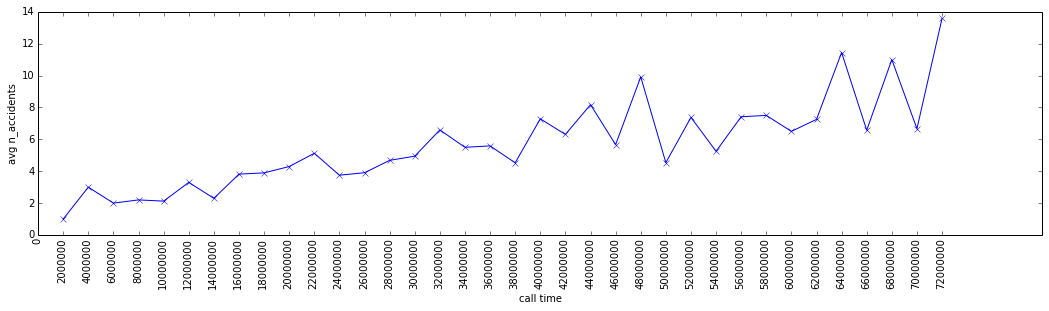

In [267]:

print('calls TIME vs number of accidents')
plt.scatter(total_time_in,I)
plt.gcf().set_size_inches(18, 4)
plt.xlabel('call time')
plt.ylabel('accidents')
#plt.xticks([ k for k in range(10)],[ k for k in range(10)])
plt.xlim(-.05,max(total_time_in))
plt.ylim(-.5,max(I))
plt.show()

print('calls TIME vs number of accidents, zoomed in')
P=np.percentile(total_time_in,95)
plt.scatter(total_time_in[(total_time_in<P)],I[(total_time_in<P)])
plt.gcf().set_size_inches(18, 4)
plt.xlabel('call time')
plt.ylabel('accidents')
#plt.xticks([ k for k in range(10)],[ k for k in range(10)])
plt.xlim(0,P)
plt.ylim(-.5,max(I[total_time_in<P]))
plt.show()

print('calls TIME vs number of accidents, no zero cells, zoomed in')
P=np.percentile(total_time_in,90)
plt.scatter(total_time_in[(total_time_in<P)&(I>0)],I[(total_time_in<P)&(I>0)])
plt.gcf().set_size_inches(18, 4)
plt.xlabel('call time')
plt.ylabel('accidents')
#plt.xticks([ k for k in range(10)],[ k for k in range(10)])
plt.xlim(0,P)
plt.ylim(-.5,max(I[total_time_in<P]))
plt.show()

print('calls TIME vs number of accidents, zoomed in')
step=2000000
philter=[step*k for k in range(int(P/step))]
plt.plot([np.average(I[(total_time_in>=k)&(total_time_in<k+step)]) for k in philter ],marker='x')
plt.xticks([ k for k in range(len(philter))],philter,rotation='vertical')
plt.gcf().set_size_inches(18, 4)
plt.ylabel('avg n_accidents')
plt.xlabel('call time')
plt.show()


print('calls TIME vs number of accidents, zoomed in, no zero-cells')
step=2000000
philter=[step*k for k in range(int(P/step))]
plt.plot([np.average(I[(total_time_in>=k)&(total_time_in<k+step)&(I>0)]) for k in philter ],marker='x')
plt.xticks([ k for k in range(len(philter))],philter,rotation='vertical')
plt.gcf().set_size_inches(18, 4)
plt.ylabel('avg n_accidents')
plt.xlabel('call time')
plt.show()


In [4]:
len(ids)

928

In [21]:
2**(108)

324518553658426726783156020576256L

In [20]:
sum(I>10)

108